<a href="https://colab.research.google.com/github/patel-zeel/blog/blob/master/_notebooks/2022-05-14-Iteratively_reweighted_least_squares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iteratively reweighted least squares (IRLS) logistic regression
> Implementation of IRLS from Probabilistic ML book of Dr. Kevin Murphy and its comparison with naive second order implementation.

- toc: true
- badges: true
- comments: true
- author: Zeel B Patel
- categories: [ML]

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import time

# Enable high precision
from jax.config import config
config.update("jax_enable_x64", True)

# To enable animation inside notebook
plt.rc("animation", html="jshtml")

## Create dataset

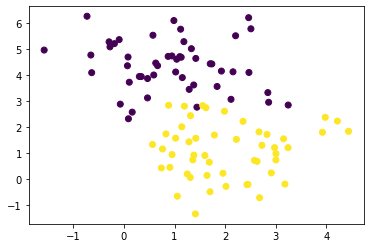

In [ ]:
features, labels = make_blobs(100, n_features=2, centers=2, random_state=0)
plt.scatter(features[:, 0], features[:, 1], c=labels);

In [ ]:
print(features.shape, features.dtype, labels.shape, labels.dtype)

(100, 2) float64 (100,) int64


## Implementing Newton's method (naive way)

We will first try to implement Eq. 10.31 directly from PML book1:

$$
\boldsymbol{w}_{t+1}=\boldsymbol{w}_{t}-\eta_{t} \mathbf{H}_{t}^{-1} \boldsymbol{g}_{t}
$$

In [ ]:
def get_logits(params, feature):  # for a single data-point
  logits = jnp.sum(feature * params["w"]) + params["b"]
  return logits

def naive_loss(params, feature, label):  # for a single data-point
  logits = get_logits(params, feature)
  prob = jax.nn.sigmoid(logits)

  # Check if label is 1 or 0
  is_one = (label == 1)
  loss_if_one = lambda: -jnp.log(prob)  # loss if label is 1
  loss_if_zero = lambda: -jnp.log(1 - prob)  # loss if labels is 0

  # Use lax.cond to convert if..else.. in jittable format
  loss = jax.lax.cond(is_one, loss_if_one, loss_if_zero)

  return loss

def naive_loss_batch(params, features, labels):  # for a batch of data-points
   losses = jax.vmap(naive_loss, in_axes=(None, 0, 0))(params, features, labels)
   return jnp.mean(losses)

Writing the train function

In [ ]:
def naive_train_step(params, features, labels, learning_rate):
  # Find gradient
  loss_value, grads = jax.value_and_grad(naive_loss_batch)(params, features, labels)

  # Find Hessian
  hess = jax.hessian(naive_loss_batch)(params, features, labels)

  # Adjust Hessian matrix nicely
  hess_matrix = jnp.block([[hess["b"]["b"], hess["b"]["w"]],
                           [hess["w"]["b"], hess["w"]["w"]]])
  
  # Adjust gradient vector nicely
  grad_vector = jnp.r_[grads["b"], grads["w"]]

  # Find H^-1g
  h_inv_g = jnp.dot(jnp.linalg.inv(hess_matrix), grad_vector)

  # Get back the structure
  h_inv_g = {"b": h_inv_g[0], "w": h_inv_g[1:]}

  # Apply the update
  params = jax.tree_map(lambda p, g: p - learning_rate*g, params, h_inv_g)

  return params, loss_value

# First order method
# vg = jax.value_and_grad(naive_loss_batch)
# def train_step(params, features, labels, learning_rate):
#   # Find gradient
#   loss_value, grads = vg(params, features, labels)

#   # Apply the update
#   params = jax.tree_map(lambda p, g: p - learning_rate*g, params, grads)

#   return params, loss_value

In [ ]:
key = jax.random.PRNGKey(0)
random_params = jax.random.normal(key, shape=(3, ))
# "b" should have shape (1,) for hessian trick with jnp.block to work
params = {"w": random_params[:2], "b": random_params[2].reshape(1,)}
learning_rate = 1.0
epochs = 20

train_step_jitted = jax.jit(naive_train_step)

history = {"loss": [], "params": []}

# warm up
train_step_jitted(params, features, labels, learning_rate)

init = time()
for _ in range(epochs):
  history["params"].append(params)
  params, loss_value = train_step_jitted(params, features, labels, learning_rate)
  history["loss"].append(loss_value)
print(time() - init, "seconds")
print(params)

0.0015490055084228516 seconds
{'b': DeviceArray([13.22076694], dtype=float64), 'w': DeviceArray([ 0.59021174, -5.18797851], dtype=float64)}


A helper function to animate the learning.

In [ ]:
def animate(history):
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  def update(idx):
    # Clear previous frame
    ax[0].cla()
    ax[1].cla()

    # Plot data
    params = history["params"][idx]
    losses = history["loss"][:idx]
    ax[0].scatter(features[:, 0], features[:, 1], c=labels)
    
    # Calculate and plot decision boundary
    x0_min, x0_max = features[:, 0].min(), features[:, 0].max()
    x1_min = -(params["b"] + params["w"][0] * x0_min)/params["w"][1]
    x1_max = -(params["b"] + params["w"][0] * x0_max)/params["w"][1]

    ax[0].plot([x0_min, x0_max], [x1_min, x1_max], label='decision boundary')

    # Plot losses
    ax[1].plot(losses, label="loss")
    ax[1].set_xlabel("Iterations")

    ax[0].legend()
    ax[1].legend()

  anim = FuncAnimation(fig, update, range(epochs))
  plt.close()
  return anim

In [ ]:
animate(history)

## Implementing IRLS algorithm

In [ ]:
def get_s_and_z(params, feature, label):  # for a single data-point
  logits = get_logits(params, feature)
  prob = jax.nn.sigmoid(logits)
  s = prob * (1 - prob)
  z = logits + (label - prob)/s
  return s, z

def irls_train_step(params, features, labels):
  s, z = jax.vmap(get_s_and_z, in_axes=(None, 0, 0))(params, features, labels)
  S = jnp.diag(s.flatten())  # convert into a diagonal matrix

  # Add column with ones
  X = jnp.c_[jnp.ones(len(z)), features]

  # Get weights
  weights = jnp.linalg.inv(X.T@S@X)@X.T@S@z.flatten()

  # get correct format
  params = {"b": weights[0], "w": weights[1:]}

  return params

In [ ]:
key = jax.random.PRNGKey(0)
random_params = jax.random.normal(key, shape=(3,))
params = {"w": random_params[:2], "b": random_params[2]}
epochs = 20

train_step_jitted = jax.jit(irls_train_step)

irls_history = {"params": []}

# warm up
train_step_jitted(params, features, labels)

init = time()
for _ in range(epochs):
  irls_history["params"].append(params)
  params = train_step_jitted(params, features, labels)
print(time() - init, "seconds")
print(params)

0.0016303062438964844 seconds
{'b': DeviceArray(13.22076694, dtype=float64), 'w': DeviceArray([ 0.59021174, -5.18797851], dtype=float64)}


## Comparison

In [ ]:
naive_params_b = list(map(lambda x: x["b"], history["params"]))
irls_params_b = list(map(lambda x: x["b"], irls_history["params"]))

naive_params_w = list(map(lambda x: x["w"], history["params"]))
irls_params_w = list(map(lambda x: x["w"], irls_history["params"]))

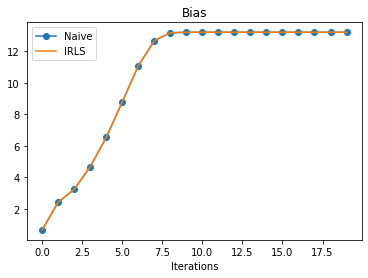

In [ ]:
plt.plot(naive_params_b, "o-", label="Naive")
plt.plot(irls_params_b, label="IRLS")
plt.xlabel("Iterations")
plt.title("Bias")
plt.legend();

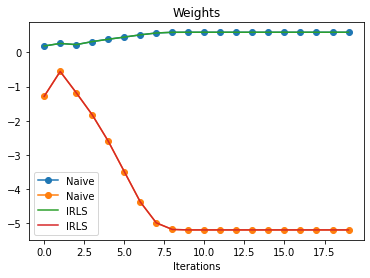

In [ ]:
plt.plot(naive_params_w, "o-", label="Naive")
plt.plot(irls_params_w, label="IRLS")
plt.xlabel("Iterations")
plt.title("Weights")
plt.legend();